<a href="https://colab.research.google.com/github/Alidine89/microalidine.github.io/blob/main/%F0%9F%94%92_Malicious_URL_Detector_XGBoost_vs_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Malicious URL Classification

📖 In this project, I developed a Malicious URL Detection system using machine learning algorithms including XGBoost Classifier, K-Nearest Neighbors, and Random Forest. The dataset consists of URLs labeled as benign or malicious, and I applied extensive feature engineering to extract meaningful insights from the URL text. I also visualized keyword patterns using WordCloud to better understand the linguistic trends in malicious URLs.

🎯 The project is designed to identify harmful links and protect users from phishing, spam, and other cybersecurity threats through intelligent URL analysis.

🔍 What’s Covered?              
✅ Feature Engineering from raw URLs                            
✅ Training ML models: XGBoost, KNN, and Random Forest          
✅ Hyperparameter tuning and model evaluation                
✅ WordCloud visualization for malicious keywords              
✅ Comparison of model performance metrics             
✅ Accuracy

##1- Importing Required Libraries 📦

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from wordcloud import WordCloud

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")

print("Path to dataset files:", path)

In [2]:
#!/bin/bash
curl -L -o ~/Downloads/malicious-urls-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/sid321axn/malicious-urls-dataset

##2- Loading Dataset 🗂️

In [4]:
df = pd.read_csv('/content/malicious-urls-dataset/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


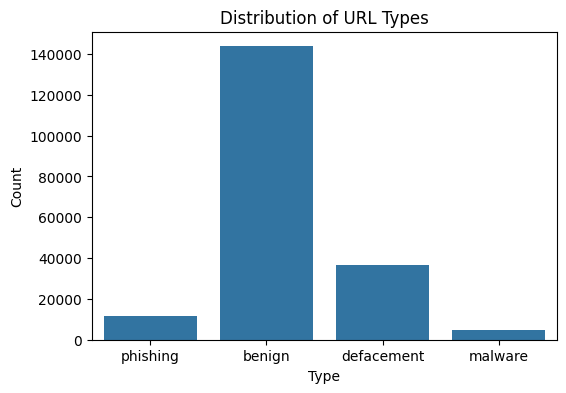

In [5]:
# ---  Distribution of URL Types ---
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df)
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

##3- Generating WordClouds for Each URL Category 🌐

In [6]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

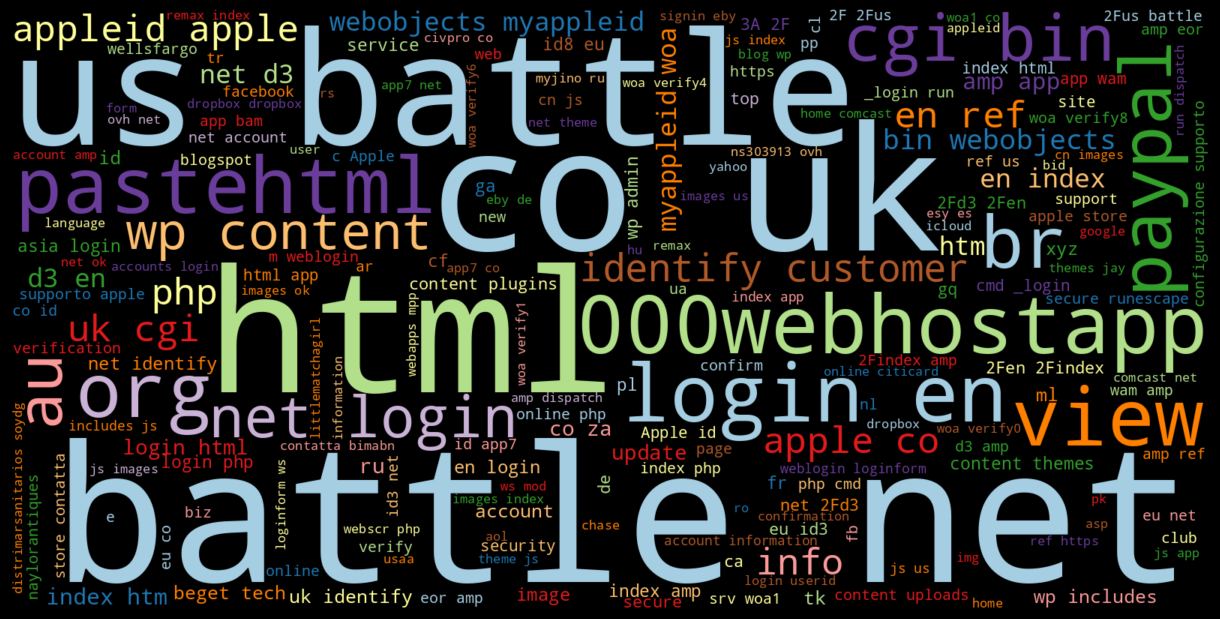

In [7]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

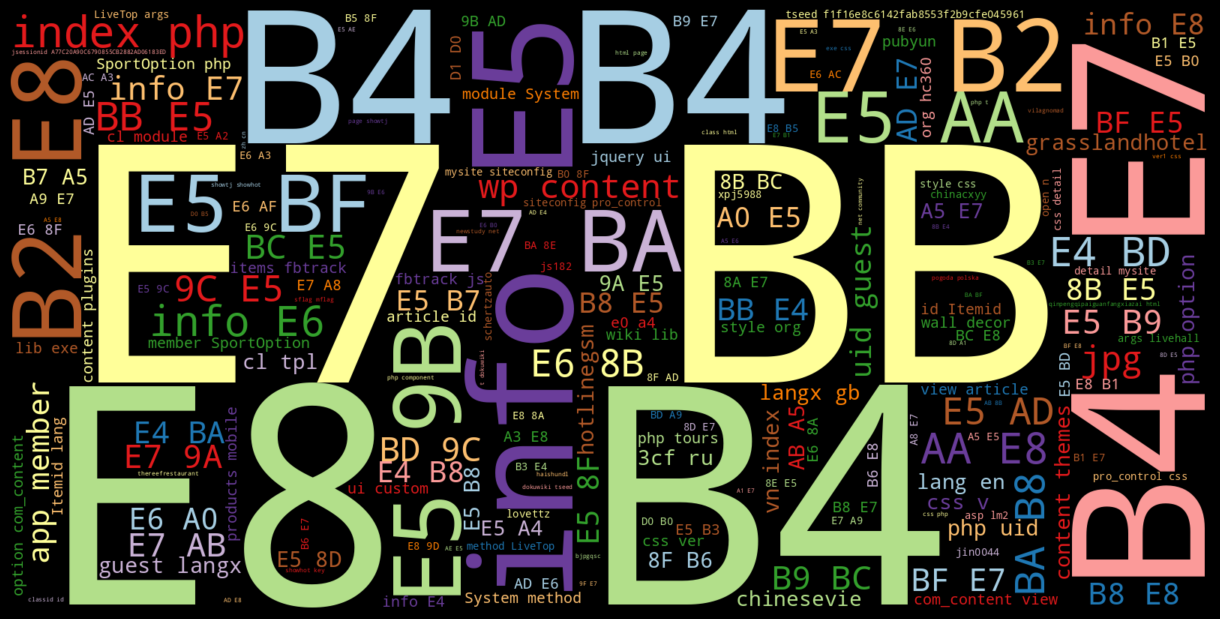

In [8]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

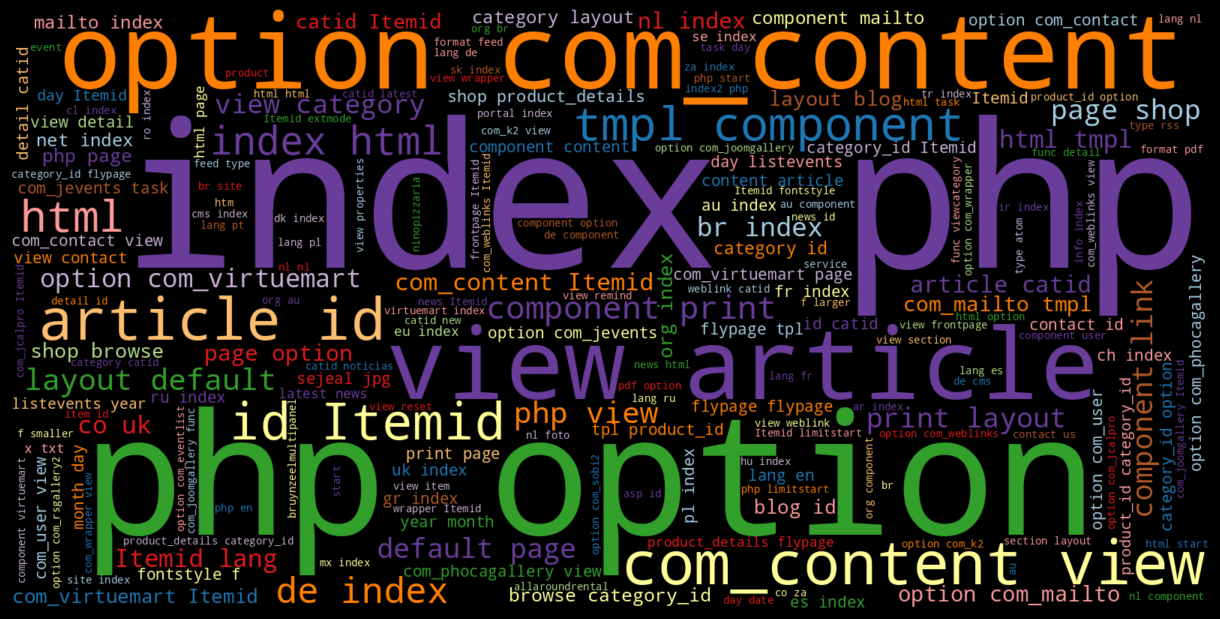

In [9]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

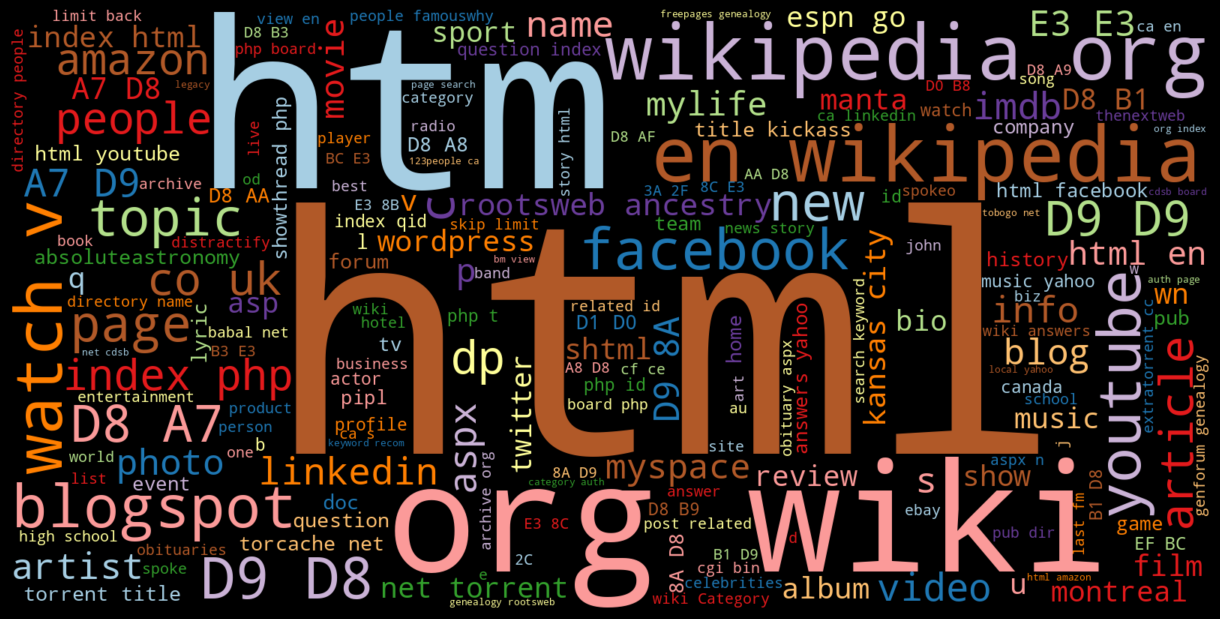

In [10]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

##4- Checking Missing Data 🔍

In [11]:
# Check for missing values
print(df.isnull().sum())

url     0
type    1
dtype: int64


##5- Encoding Target Labels 🏷️

In [12]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['type'])

In [13]:
df

,url,type,label_encoded
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
196559,http://bill-verizon.7billpay-aol.com/ForYourHo...,phishing,3
196560,http://www.thegreenscene.info/hydroseeding,defacement,1
196561,https://500px.com/photo/104320951/sunset-flyin...,benign,0
196562,alternet.org/economy/149930/wisc._governor_mak...,benign,0


##6-Lexical Feature Extraction 🔍

In [14]:
# suspicious keywords often seen in phishing or malicious URLs
suspicious_keywords = ['login', 'signin', 'verify', 'update', 'banking', 'account', 'secure', 'ebay', 'paypal']

# feature extraction function
def extract_features(url):
    features = {}

    # Total length of the URL
    features['url_length'] = len(url)

    # Number of digits in the URL
    features['num_digits'] = sum(c.isdigit() for c in url)

    # Number of special characters (punctuation) in the URL
    features['num_special_chars'] = sum(c in string.punctuation for c in url)

    # Number of subdomains (i.e., number of dots minus one)
    features['num_subdomains'] = url.count('.') - 1

    # Whether the URL contains an IP address instead of a domain
    features['has_ip'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0

    # Whether the URL uses HTTPS
    features['has_https'] = int('https' in url.lower())

    # Number of query parameters (indicated by '?')
    features['num_params'] = url.count('?')

    # Number of URL fragments (indicated by '#')
    features['num_fragments'] = url.count('#')

    # Total number of slashes in the URL
    features['num_slashes'] = url.count('/')

    # Whether the URL contains any suspicious keywords
    features['has_suspicious_words'] = int(any(word in url.lower() for word in suspicious_keywords))

    # Length of the top-level domain (e.g., "com", "net")
    tld = url.split('.')[-1]
    features['tld_length'] = len(tld)

    # Whether the TLD is a common one
    features['is_common_tld'] = int(tld in ['com', 'org', 'net', 'edu', 'gov'])

    # Whether the URL contains hexadecimal encoding (e.g., "%2F")
    features['has_hex'] = int(bool(re.search(r'%[0-9a-fA-F]{2}', url)))

    # Whether the URL has repeated characters (e.g., "aaaaa", "1111")
    features['repeated_chars'] = int(bool(re.search(r'(.)\1{3,}', url)))

    return pd.Series(features)

# Apply feature extraction
features_df = df['url'].apply(extract_features)
df = pd.concat([df, features_df], axis=1)
df.head()

,url,type,label_encoded,url_length,num_digits,num_special_chars,num_subdomains,has_ip,has_https,num_params,num_fragments,num_slashes,has_suspicious_words,tld_length,is_common_tld,has_hex,repeated_chars
0,br-icloud.com.br,phishing,3,16,0,3,1,0,0,0,0,0,0,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,1,5,1,0,0,0,0,2,0,4,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,1,5,1,0,0,0,0,3,0,3,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,7,18,2,0,0,1,0,3,0,53,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,22,14,1,0,0,1,0,3,0,198,0,0,0


##7- Feature Correlation Analysis 🌡️

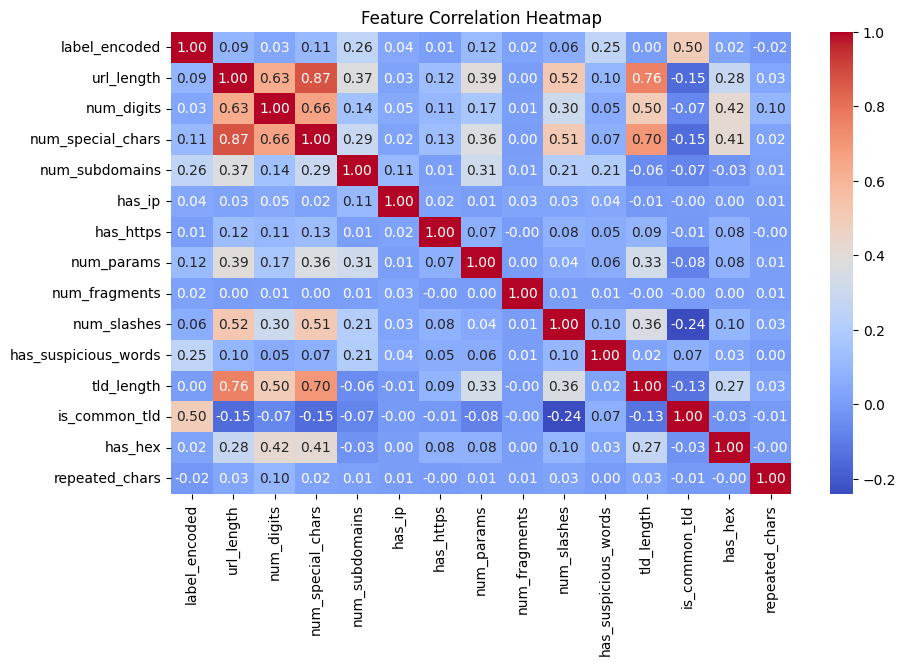

In [15]:
# --- 1 Correlation Heatmap ---
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

##8-Model Training & Evaluation 📊

In [17]:
# Define features and target
X = df.drop(columns=['url', 'type', 'label_encoded'])
y = df['label_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionary to store model accuracies
accuracies = {}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Accuracy for {name}: {acc:.4f}")
    print(f"Classification Report for {name}:")

    # Get the unique labels present in y_test
    current_labels = np.unique(y_test)
    # Map these labels back to their original names using the label_encoder
    current_target_names = label_encoder.inverse_transform(current_labels)

    print(classification_report(y_test, y_pred, target_names=current_target_names))
    print("\n")

Training XGBoost...
Accuracy for XGBoost: 0.9653
Classification Report for XGBoost:
              precision    recall  f1-score   support

      benign       0.98      0.98      0.98     28684
  defacement       0.92      0.93      0.93      7341
     malware       0.94      0.77      0.85       915
    phishing       0.94      0.91      0.92      2373

    accuracy                           0.97     39313
   macro avg       0.95      0.90      0.92     39313
weighted avg       0.97      0.97      0.97     39313



Training Random Forest...
Accuracy for Random Forest: 0.9705
Classification Report for Random Forest:
              precision    recall  f1-score   support

      benign       0.98      0.99      0.98     28684
  defacement       0.93      0.94      0.94      7341
     malware       0.96      0.83      0.89       915
    phishing       0.94      0.91      0.92      2373

    accuracy                           0.97     39313
   macro avg       0.95      0.92      0.93     393

##9-Model Accuracy Comparison 📊

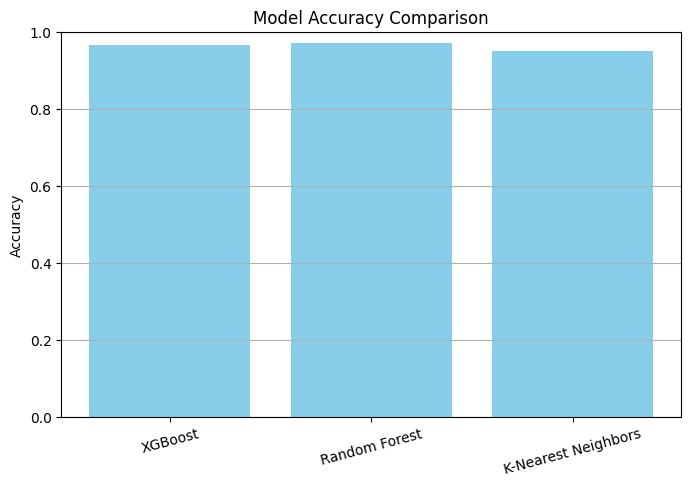

In [18]:
# Plot model accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

##Conclusion:

 . The models show varying degrees of performance in classifying malicious URLs
 . Feature engineering plays a crucial role in model accuracy.
 . Further improvements can be made by incorporating more advanced features or using deep learning models.